In [1]:
from langchain_core.tools import tool
from typing_extensions import Literal, TypedDict
from langchain.chat_models import ChatOpenAI
from langchain_anthropic import ChatAnthropic
import os

from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
from IPython.display import Image, display

In [2]:
x: list[str]=[]
x.append(10)
x

[10]

In [3]:
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
ANTHROPIC_API_KEY = os.environ.get("ANTHROPIC_API_KEY")

# llm = ChatOpenAI(model_name="gpt-3.5-turbo", openai_api_key=OPENAI_API_KEY)
llm = ChatAnthropic(model="claude-3-5-sonnet-latest", anthropic_api_key=ANTHROPIC_API_KEY)

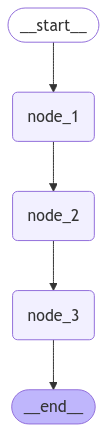

{'user_input': 'My'}


{'graph_output': 'My name is Lance', 'foo': 'OVERWRITE'}

In [22]:
class InputState(TypedDict):
    user_input: str
    def __init__(self):
        self.check = "checking if this works"

class OutputState(TypedDict):
    graph_output: str
    foo: str

class OverallState(TypedDict):
    foo: str
    user_input: str
    graph_output: str

class PrivateState(TypedDict):
    bar: str

def node_1(state: InputState) -> OverallState:
    # Write to OverallState
    print(state)
    return {"foo": state["user_input"] + " name"}

def node_2(state: OverallState) -> PrivateState:
    # Read from OverallState, write to PrivateState
    return {"bar": state["foo"] + " is"}

def node_3(state: PrivateState) -> OutputState:
    # Read from PrivateState, write to OutputState
    return {"graph_output": state["bar"] + " Lance",
            "foo": "OVERWRITE"}

builder = StateGraph(OverallState,input=InputState,output=OutputState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

graph = builder.compile()
# Show the agent
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
graph.invoke({"user_input":"My"})

In [ ]:
# Schema for structured output
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")

# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

In [ ]:
# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""
    print("STATE MESSAGE", state['messages'])
    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content="observation", tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4. Then multiply the result by 10")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()